In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [5]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


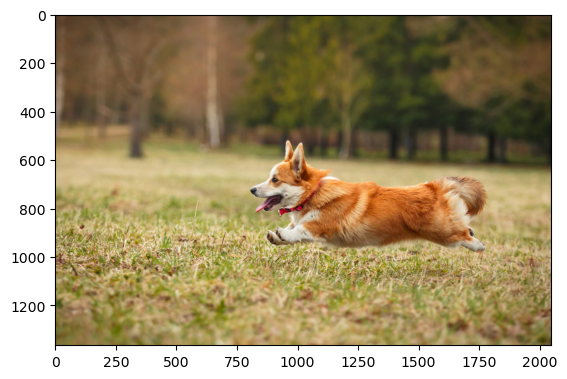

In [6]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")

# Show the image
plt.imshow(img.permute(1, 2, 0))

In [7]:
img

tensor([[[ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         ...,
         [121, 121, 122,  ...,  97,  96,  96],
         [121, 121, 122,  ...,  97,  97,  96],
         [121, 121, 122,  ...,  98,  97,  97]],

        [[ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         ...,
         [103, 103, 104,  ...,  82,  81,  81],
         [103, 103, 104,  ...,  82,  82,  81],
         [103, 103, 104,  ...,  83,  82,  82]],

        [[ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         ...,
         [ 37,  37,  38,  ...,  43,  42,  42],
         [ 37,  37,  38,  ...,  43,  43,  42],
         [ 37,  37,  38,  ...,  44,  43,  43]]], dtype=torch.uint8)

In [8]:
# [0, 1] the image
img = img / 255.0

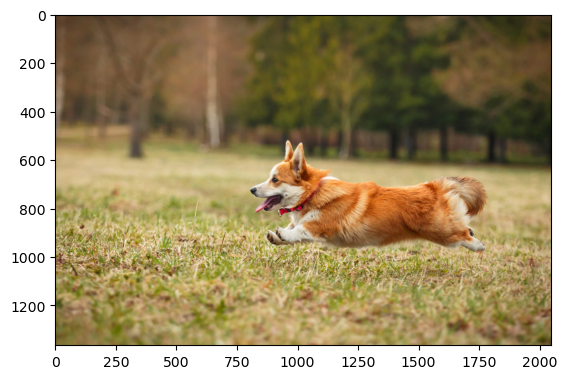

In [9]:
plt.imshow(img.permute(1, 2, 0))

In [10]:
img.shape

torch.Size([3, 1365, 2048])

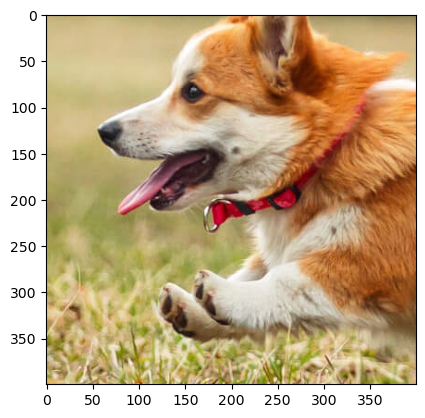

In [11]:
crop = torchvision.transforms.functional.crop(img, 600, 750, 400, 400)


# Plot the crop
plt.imshow(crop.permute(1, 2, 0))

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
img

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [14]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 400


In [15]:
# Create a coordinate dataset from the image
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height* width, 2) and torch.tensor containing the (num_channels)
    """
    
    num_channels, height, width = crop.shape
    
    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)
    
    # Combine the x and y coordinates into a single tensor
    X = torch.stack([x_coords, y_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    
    # Create a tensor containing the image pixel values
    Y = img.reshape(-1, num_channels).float().to(device)
    return X, Y


In [16]:
dog_X, dog_Y = create_coordinate_map(crop)

In [17]:
dog_X.shape, dog_Y.shape

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [18]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale

class NN(nn.Module):
    def __init__(self, activation=torch.sin, n_out=1):
        super().__init__()
        self.activation = activation
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, n_out) #gray scale image (1) or RGB (3)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        return self.fc6(x)

In [19]:
nns = {}
nns["dog"] = {}
nns["dog"]["relu"] = NN(activation=torch.relu, n_out=3).to(device)
nns["dog"]["sin"] = NN(activation=torch.sin, n_out=3).to(device)

In [20]:
nns["dog"]["relu"](dog_X).shape, nns["dog"]["sin"](dog_X).shape

(torch.Size([160000, 3]), torch.Size([160000, 3]))

In [21]:
def train(net, lr, X, Y, epochs):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
    
        if epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")


In [22]:
imgs_dog_relu = train(nns["dog"]["relu"], lr=0.001, X=dog_X, Y=dog_Y, epochs=100)

Epoch 0 loss: 1.901922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


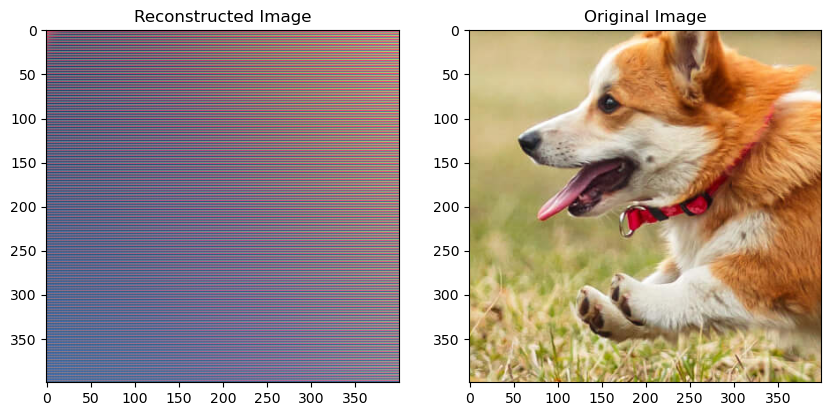

In [23]:
def plot_reconstructed_and_original_image(original_img, net, X):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(num_channels, height, width)
        outputs = outputs.permute(1, 2, 0)
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(outputs.cpu())
    ax[0].set_title("Reconstructed Image")
    ax[1].imshow(original_img.permute(1, 2, 0))
    ax[1].set_title("Original Image")

plot_reconstructed_and_original_image(crop, nns["dog"]["relu"], dog_X)

In [24]:
imgs_dog_sin = train(nns["dog"]["sin"], lr=0.001, X=dog_X, Y=dog_Y, epochs=100)

Epoch 0 loss: 0.369405


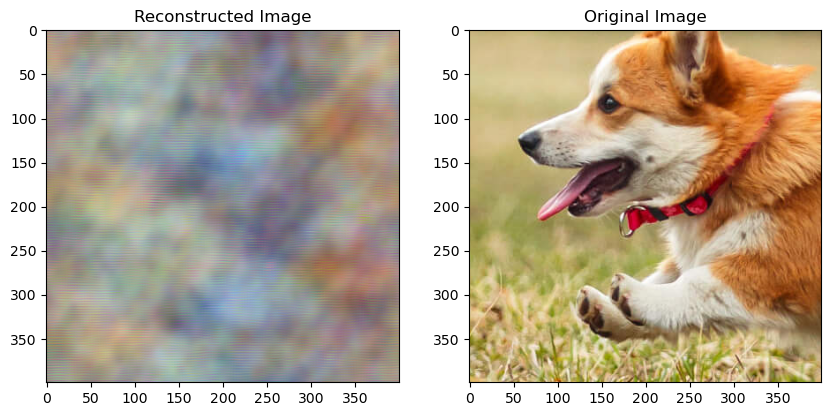

In [25]:
plot_reconstructed_and_original_image(crop, nns["dog"]["sin"], dog_X)

In [30]:
context_lengths = [5, 10, 100, 1000, 10000]

In [28]:
# Now, reconstruct the image using a sine activation function with varying number of context points (subsampled from the original image)

test_nets_sirens = {}

# Shuffled dataset
dog_X, dog_Y = create_coordinate_map(crop)

# shuffled index
sh_index = torch.randperm(dog_X.shape[0])

# Shuffle the dataset
dog_X_sh = dog_X[sh_index]
dog_Y_sh = dog_Y[sh_index]

print(dog_X_sh.shape, dog_Y_sh.shape)

for num_context in context_lengths:
    print(f"Number of context points: {num_context}")
    test_nets_sirens[num_context] = NN(activation=torch.sin, n_out=3).to(device)
    train(test_nets_sirens[num_context], lr=0.001, X=dog_X_sh[:num_context], Y=dog_Y[:num_context], epochs=1000)
    print()


torch.Size([160000, 2]) torch.Size([160000, 3])
Number of context points: 5
Epoch 0 loss: 0.587528
Epoch 100 loss: 0.000001
Epoch 200 loss: 0.000000
Epoch 300 loss: 0.000000
Epoch 400 loss: 0.000000
Epoch 500 loss: 0.000011
Epoch 600 loss: 0.000000
Epoch 700 loss: 0.000000
Epoch 800 loss: 0.000000
Epoch 900 loss: 0.000000

Number of context points: 10
Epoch 0 loss: 0.482429
Epoch 100 loss: 0.000001
Epoch 200 loss: 0.000000
Epoch 300 loss: 0.000000
Epoch 400 loss: 0.000000
Epoch 500 loss: 0.000000
Epoch 600 loss: 0.000000
Epoch 700 loss: 0.000004
Epoch 800 loss: 0.000000
Epoch 900 loss: 0.000000

Number of context points: 100
Epoch 0 loss: 0.516213
Epoch 100 loss: 0.000001
Epoch 200 loss: 0.000000
Epoch 300 loss: 0.000000
Epoch 400 loss: 0.000000
Epoch 500 loss: 0.000000
Epoch 600 loss: 0.000000
Epoch 700 loss: 0.000000
Epoch 800 loss: 0.000000
Epoch 900 loss: 0.000000

Number of context points: 1000
Epoch 0 loss: 0.498932
Epoch 100 loss: 0.001781
Epoch 200 loss: 0.000190
Epoch 300 loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of context points: 5
Number of context points: 10
Number of context points: 100
Number of context points: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of context points: 10000


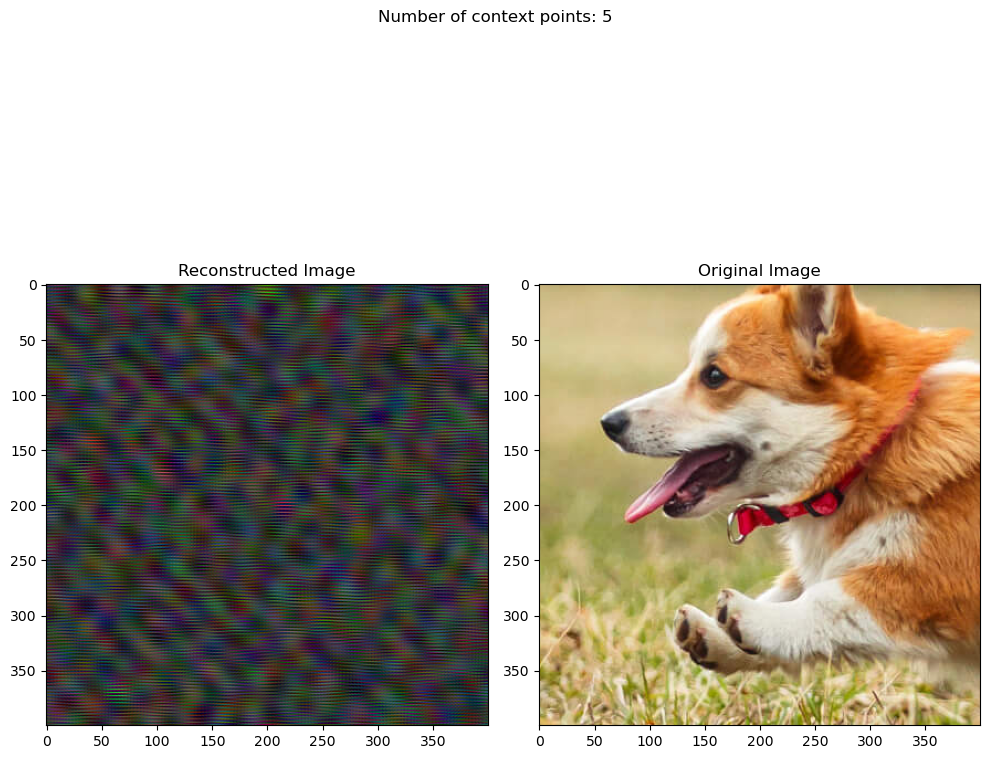

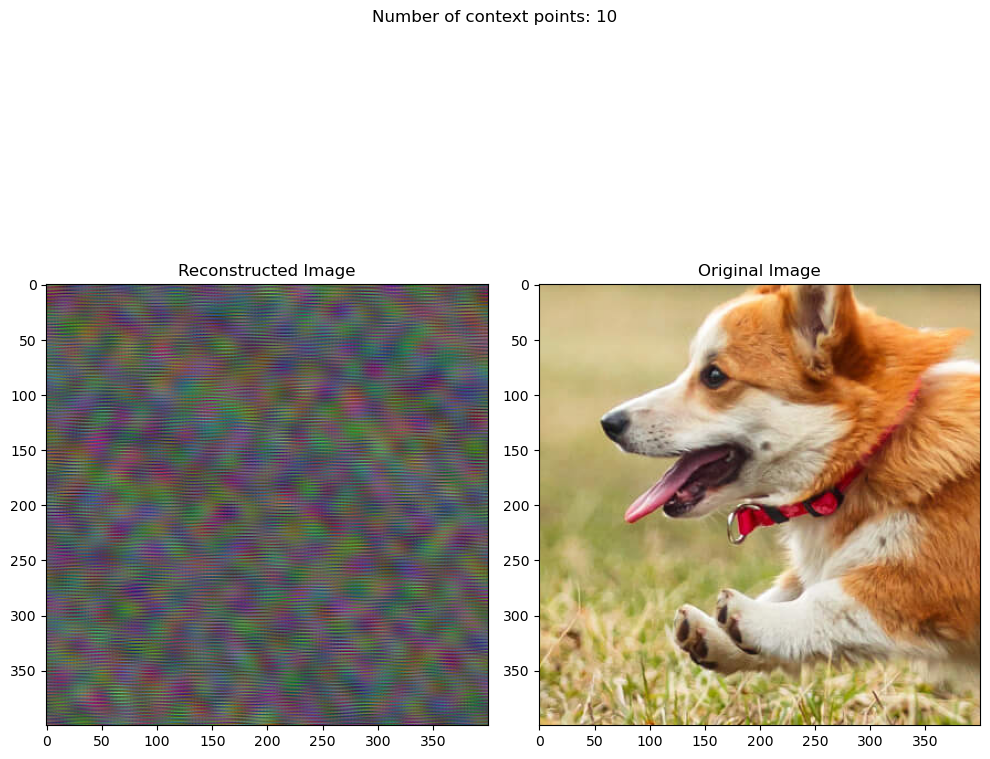

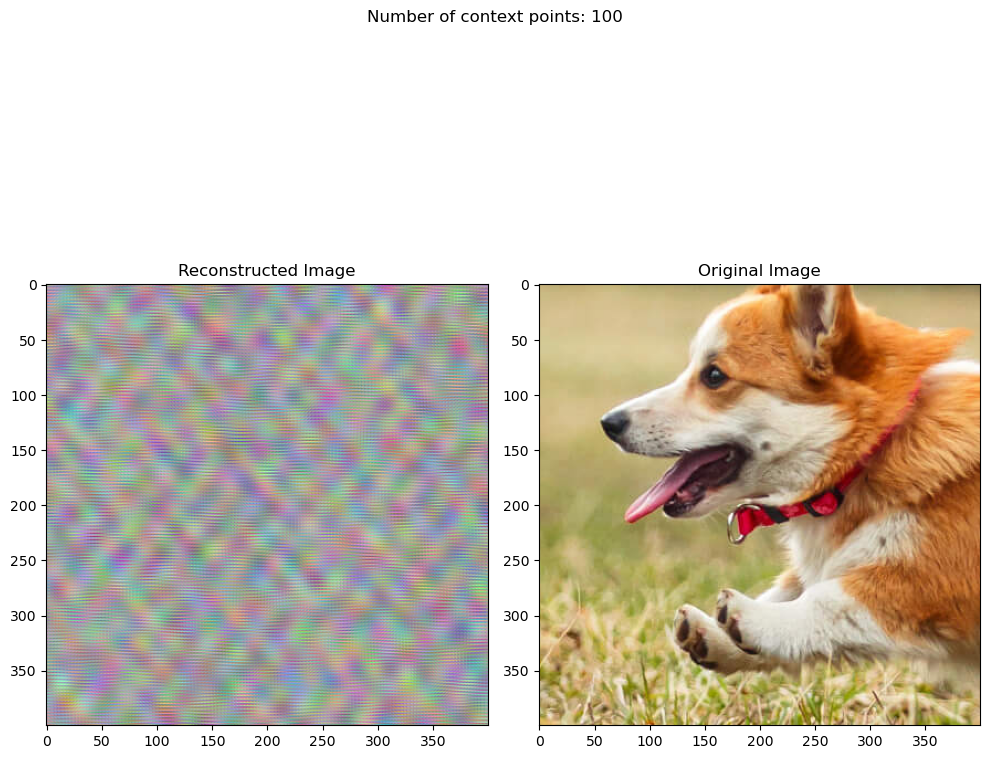

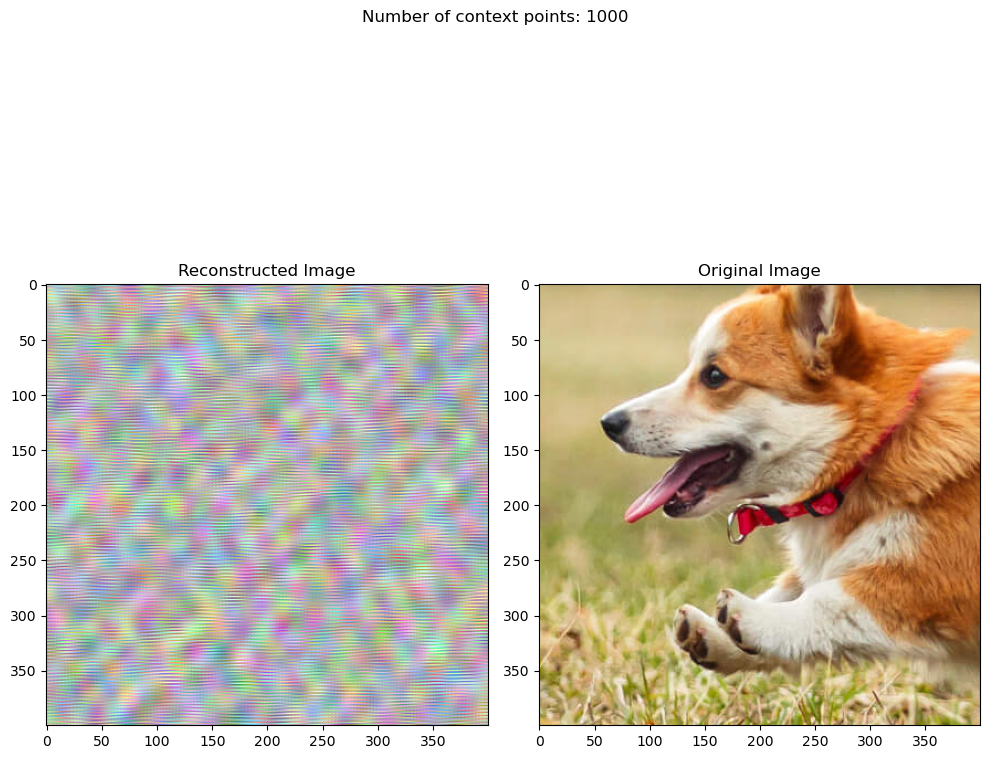

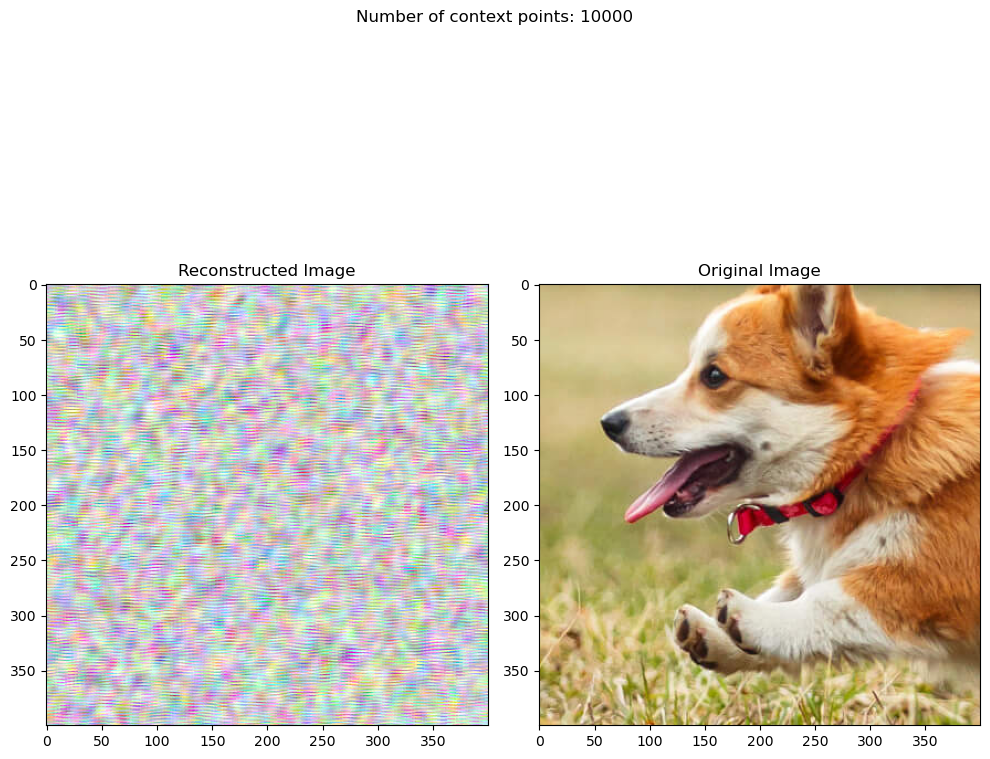

In [31]:
# Plot the reconstructed image for each number of context points

for num_context in context_lengths:
    print(f"Number of context points: {num_context}")
    plot_reconstructed_and_original_image(crop, test_nets_sirens[num_context], dog_X)
    plt.suptitle(f"Number of context points: {num_context}")
    plt.tight_layout()

In [44]:
from copy import deepcopy

input_data = deepcopy(dog_X)

net = deepcopy(nns["dog"]["relu"])

input_data.requires_grad = True  # Enable gradient computation for the input data
outputs = net(input_data)  # Forward pass

g = torch.autograd.grad(outputs, input_data, grad_outputs=torch.ones_like(outputs), create_graph=True)


In [ ]:
dog_X.shape

torch.Size([160000, 2])

In [1]:
g

NameError: name 'g' is not defined

In [40]:
# Plot the gradient of the network wrt to the input
def plot_gradient(net, img):
    """
    net: torch.nn.Module
    img: torch.Tensor of shape (num_channels, height, width)
    """
    num_channels, height, width = img.shape
    X, Y = create_coordinate_map(img)
    net.eval()
    img.requires_grad = True
    
    # Forward pass
    outputs = net(X)
    loss = nn.MSELoss()(outputs, Y)
    
    # Backward pass
    loss.backward()
    
    # Get the gradients
    grads = img.grad
    
    # Plot the gradients
    plt.imshow(grads.permute(1, 2, 0).abs())
    

plot_gradient(nns["dog"]["relu"], crop)

nns["dog"]["relu"].eval()
dog_X.requires_grad = True

# Forward pass
outputs = nns["dog"]["relu"](dog_X)

loss = nn.MSELoss()(outputs, dog_Y)

# Backward pass
loss.backward()

# Get the gradients
grads = dog_X.grad


AttributeError: 'NoneType' object has no attribute 'permute'

In [35]:
grad.


torch.Size([160000, 2])

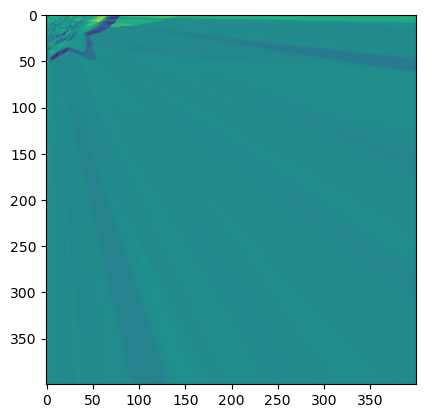

In [38]:
# Reshape the gradients
grad = grads.sum(dim=1).reshape(400, 400)

plt.imshow(grad.cpu())

In [ ]:
from astra.torch.data import load_mnist
ds, ds_name = load_mnist()

In [ ]:
ds

In [ ]:
ds.info()

In [ ]:
images = ds['img'][:100].values

# Convert the NumPy array to a PyTorch tensor
images_tensor = torch.from_numpy(images)

In [ ]:
images_tensor.shape

In [ ]:
# Plot ith image
def plot_image(i):
    plt.imshow(images_tensor[i].reshape(28, 28), cmap='gray')
    # Remove the axis
    plt.axis('off')
    plt.show()

plot_image(0)

In [ ]:
im = images_tensor[0].reshape(28, 28)
im.shape

In [ ]:
xi, yi = torch.meshgrid(torch.arange(28), torch.arange(28))
xi.shape

In [ ]:
xi.reshape(-1, 1).shape

In [ ]:
im.view(-1, 28*28)

In [ ]:
def convert_coordinate(image):
    flat_im = image.view(-1)

    # Create (x, y) coordinate pairs
    x_coords, y_coords = torch.meshgrid(torch.arange(28), torch.arange(28))

    # Flatten the coordinates as well
    # Flatten the coordinates as well
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)

    # Stack the (x, y) coordinates with the flattened image
    coordinates = torch.stack((x_coords, y_coords), dim=1)

    return coordinates, flat_im

In [ ]:
convert_coordinate(im)

In [ ]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale

class NN(nn.Module):
    def __init__(self, activation=torch.sin, n_out=1):
        super().__init__()
        self.activation = activation
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, n_out) #gray scale image (1) or RGB (3)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        return self.fc6(x)

In [ ]:
nn_relu = NN(activation=F.relu)

nn_relu.activation

In [ ]:
nn_relu(convert_coordinate(im)[0])

In [ ]:
def train(model, image, epochs=1000, lr=0.01):
    # Convert the image to (x, y) coordinates and pixel values
    coordinates, pixel_values = convert_coordinate(image)

    # Define the loss function
    loss_fn = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    for i in range(epochs):
        # Forward pass
        pred = model(coordinates)
        print(pred.shape)
        

        # Compute the loss
        loss = loss_fn(pred, pixel_values)

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch: {i}, Loss: {loss.item():.4f}')

In [ ]:
train(nn_relu, im)